In [1]:
import os
import re
import pandas as pd
from time import time
from datetime import datetime, timedelta
import numpy as np
import nltk
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
RANDOM_SEED = 7
DATA_DIR = "../../../data/"
INTERM_DIR = '../compiled_data'

twitter_data_path = os.path.join(DATA_DIR, 'final/tweets_data_final.csv')
replies_data_path = os.path.join(DATA_DIR, 'final/replies_data_final.csv')
bitcoin_data_path = os.path.join(DATA_DIR, 'final/bitcoin_minutely_data.csv')
sentiment_data_path = os.path.join(DATA_DIR, 'final/sentiment_score.csv')

nlp = spacy.load("en_core_web_sm")

In [287]:
#df_total = pd.read_csv(twitter_data_path)
#pd.read_csv(bitcoin_data_path)


In [3]:
def load_twitter_data(data_path, nrows=None, cols=['text', 'conversation_id','created_at', 'retweet_count', 'reply_count', 'like_count','quote_count', 'is_reply_to_user', 'related_user_id',]):
    "Load twitter data, nrows None indicates all rows, otherwise specified integer of rows"
    data = pd.read_csv(data_path, nrows = nrows, delimiter=',', usecols=cols)
    data = data[data['text'] != '']
    data['created_at'] = pd.to_datetime(data['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
    return data

In [4]:
def load_bitcoin(data_path):
    asset = pd.read_csv(data_path)
    asset = asset.dropna()
    asset['time'] = pd.to_datetime(asset['time'])
    #asset["log_ret"] = np.log(asset.prc).diff(1)
    return asset #["log_ret"]

In [370]:
twitter_df = load_twitter_data(twitter_data_path, 30)
replies_df = load_twitter_data(replies_data_path, 30)
bitcoin_df = load_bitcoin(bitcoin_data_path)
sentiment = pd.read_csv(sentiment_data_path, nrows = 30, delimiter=',')


In [9]:
sentiment.head()

,text,conversation_id,created_at,retweet_count,reply_count,like_count,quote_count,is_reply_to_user,related_user_id,Pos,Tag,Dep,Shape,neg_sa,pos_sa,neu_sa,compound_sa
0,If your long term conviction of bitcoin’s valu...,1525612785375264768,2022-05-14 23:03:27,378,196,2546,42,0,339061487,"['SCONJ', 'PRON', 'ADJ', 'NOUN', 'NOUN', 'ADP'...","['IN', 'PRP$', 'JJ', 'NN', 'NN', 'IN', 'NN', '...","['mark', 'poss', 'amod', 'compound', 'nsubj', ...","['Xx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xx', '...",0.000,0.118,0.882,0.3400
1,"We have helped nearly 1,000 people get a new j...",1525490438093799424,2022-05-14 14:57:17,50,87,331,4,0,339061487,"['PRON', 'AUX', 'VERB', 'ADV', 'NUM', 'NOUN', ...","['PRP', 'VBP', 'VBN', 'RB', 'CD', 'NNS', 'VBP'...","['nsubj', 'aux', 'ROOT', 'advmod', 'nummod', '...","['Xx', 'xxxx', 'xxxx', 'xxxx', 'd,ddd', 'xxxx'...",0.000,0.121,0.879,0.6052
2,Bitcoin is the best first principles solution ...,1525234174046658565,2022-05-13 21:58:59,209,231,1380,24,0,339061487,"['PROPN', 'AUX', 'DET', 'ADJ', 'ADJ', 'NOUN', ...","['NNP', 'VBZ', 'DT', 'JJS', 'JJ', 'NNS', 'NN',...","['nsubj', 'ROOT', 'det', 'amod', 'amod', 'comp...","['Xxxxx', 'xx', 'xxx', 'xxxx', 'xxxx', 'xxxx',...",0.128,0.221,0.651,0.6908
3,I have officially been writing a letter on tec...,1525106011849347078,2022-05-13 13:29:42,34,101,373,3,0,339061487,"['PRON', 'AUX', 'ADV', 'AUX', 'VERB', 'DET', '...","['PRP', 'VBP', 'RB', 'VBN', 'VBG', 'DT', 'NN',...","['nsubj', 'aux', 'advmod', 'aux', 'ROOT', 'det...","['X', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'x', 'xx...",0.000,0.235,0.765,0.9061
4,"[NEW POST] Some Thoughts On LUNA / UST\n\n""The...",1524944753753735178,2022-05-13 02:48:56,96,192,636,14,0,339061487,"['X', 'ADJ', 'PROPN', 'PUNCT', 'DET', 'PROPN',...","['XX', 'JJ', 'NNP', '-RRB-', 'DT', 'NNPS', 'IN...","['punct', 'compound', 'ROOT', 'punct', 'det', ...","['[', 'XXX', 'XXXX', ']', 'Xxxx', 'Xxxxx', 'Xx...",0.426,0.000,0.574,-0.9719


In [371]:
total_df = pd.concat([twitter_df, replies_df], ignore_index=True)

#total_df.groupby(twitter_df["created_at"].dt.day)[['text']].count().plot(kind="bar")
# total_df.groupby(twitter_df["created_at"].apply(lambda x: datetime.datetime.fromisoformat(x)).dt.day)[['text']].count().plot(kind="bar")
# Put histogram for two types replies and twitter to see activity difference

In [166]:
def rem_url_at(df):
    raw = []
    for sentence in tqdm(df['text']):
        sentence = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'
                          '(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', sentence)
        sentence = re.sub("(@[A-Za-z0-9_]+)", "", sentence)
        raw.append(sentence)
    df['text'] = raw
    return df

In [164]:
def tagging(df):
    pos,tag,dep,shape = [],[],[],[]
    for sentence in tqdm(df['text']):
        pos_tmp,tag_tmp,dep_tmp,shape_tmp = [],[],[],[]
        for token in nlp(sentence):
            pos_tmp.append(token.pos_)
            tag_tmp.append(token.tag_)
            dep_tmp.append(token.dep_)
            shape_tmp.append(token.shape_)
        pos.append(pos_tmp)
        tag.append(tag_tmp)
        dep.append(dep_tmp)
        shape.append(shape_tmp)
    df['Pos'] = pos
    df['Tag'] = tag
    df['Dep'] = dep
    df['Shape'] = shape
    return df

In [163]:
def cleaning(df): 
    df = rem_url_at(df)
    df = tagging(df)
    df.replace('', np.nan, inplace=True)
    #df = df.dropna(how='any', axis=0)
    df = df[df['text'].map(
        lambda d: len(d)) > 0]
    return df

In [167]:
total_df = cleaning(total_df)

100%|██████████| 8/8 [00:00<00:00, 49.97it/s]


In [313]:
total_df.head()

,text,conversation_id,created_at,retweet_count,reply_count,like_count,quote_count,is_reply_to_user,related_user_id,Pos,Tag,Dep,Shape
0,If your long term conviction of bitcoin’s valu...,1525612785375264768,2022-05-14 23:03:27+00:00,378,196,2546,42,0,339061487,"[SCONJ, PRON, ADJ, NOUN, NOUN, ADP, NOUN, PART...","[IN, PRP$, JJ, NN, NN, IN, NN, POS, NN, VBN, I...","[mark, poss, amod, compound, nsubj, prep, nmod...","[Xx, xxxx, xxxx, xxxx, xxxx, xx, xxxx, ’x, xxx..."
1,"We have helped nearly 1,000 people get a new j...",1525490438093799424,2022-05-14 14:57:17+00:00,50,87,331,4,0,339061487,"[PRON, AUX, VERB, ADV, NUM, NOUN, VERB, DET, A...","[PRP, VBP, VBN, RB, CD, NNS, VBP, DT, JJ, NN, ...","[nsubj, aux, ROOT, advmod, nummod, nsubj, ccom...","[Xx, xxxx, xxxx, xxxx, d,ddd, xxxx, xxx, x, xx..."
2,Bitcoin is the best first principles solution ...,1525234174046658565,2022-05-13 21:58:59+00:00,209,231,1380,24,0,339061487,"[PROPN, AUX, DET, ADJ, ADJ, NOUN, NOUN, ADP, A...","[NNP, VBZ, DT, JJS, JJ, NNS, NN, IN, JJ, IN, D...","[nsubj, ROOT, det, amod, amod, compound, attr,...","[Xxxxx, xx, xxx, xxxx, xxxx, xxxx, xxxx, xx, x..."
3,I have officially been writing a letter on tec...,1525106011849347078,2022-05-13 13:29:42+00:00,34,101,373,3,0,339061487,"[PRON, AUX, ADV, AUX, VERB, DET, NOUN, ADP, NO...","[PRP, VBP, RB, VBN, VBG, DT, NN, IN, NN, ,, JJ...","[nsubj, aux, advmod, aux, ROOT, det, dobj, pre...","[X, xxxx, xxxx, xxxx, xxxx, x, xxxx, xx, xxxx,..."
4,If the fact the US government can freeze it d...,1525612785375264768,2022-05-14 23:05:38+00:00,0,11,26,0,1,339061487,"[SPACE, SCONJ, DET, NOUN, DET, PROPN, NOUN, AU...","[_SP, IN, DT, NN, DT, NNP, NN, MD, VB, PRP, VB...","[dep, mark, det, nsubj, det, compound, nsubj, ...","[ , Xx, xxx, xxxx, xxx, XX, xxxx, xxx, xxxx, x..."


## Sentiment Analyser
- Flair
- Vader
- Blob

In [314]:
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')

2022-05-26 11:58:21,129 loading file /Users/ade/.flair/models/sentiment-en-mix-distillbert_4.pt


In [315]:
def sentiment_analyser(df):
    df_vader = []
    for sentence in tqdm(df['text'], position=0):
        df_vader.append(vader(sentence))
    sa_df = pd.DataFrame(df_vader)
    sa_df.index = df.index
    df['neg_sa'] = sa_df['neg']
    df['pos_sa'] = sa_df['pos']
    df['neu_sa'] = sa_df['neu']
    df['compound_sa'] = sa_df['compound']
    return df

In [316]:
def vader(sentence):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(sentence)
    return sentiment

In [ ]:
def blob(sentence):
    sentiment = TextBlob(sentence).sentiment.polarity
    return sentiment

In [ ]:
def fler(sentence):
    s = Sentence(sentence)
    classifier.predict(s)
    sentiment = str(s.labels[0])
    num = float(re.findall(r'\d+\.\d+', sentiment)[0])
    if sentiment.find('POSITIVE') == -1:
        num = num * -1
    return num

In [ ]:
## Moved away from using multiple senttiment analysis models, too much computation time, Vader most adapted to social media
# def sentiment_analyser(df, v=True, f=False, b=False, r_vader=0.8, r_fler=0.1, r_blob=0.1):
#     df_fler, df_vader, df_blob = [], [], []
#     for sentence in tqdm(df['body'], position=0):
#         if v:
#             df_vader.append(vader(sentence))
#         if f:
#             df_fler.append(fler(sentence))
#         if b:
#             df_blob.append(blob(sentence))
#     if v: 
#         df['VADER'] = df_vader
#     if f: 
#         df['FLAIR'] = df_fler
#     if b:
#         df['BLOB'] = df_blob
#     if v and f and b:
#         df['compound'] = df['VADER']*r_vader + \
#             df['FLAIR']*r_fler + df['BLOB']*r_blob
#     elif v and f and not b:
#         df['compound'] = df['VADER']*(r_vader+r_blob) + df['FLAIR']*r_fler
#     elif v and b and not f:
#         df['compound'] = df['VADER']*(r_vader+r_fler) + df['BLOB']*r_blob
#     else:
#         df['compound'] = df['VADER']
#     return df

In [317]:
total_df = sentiment_analyser(total_df)
total_df.head()

100%|██████████| 8/8 [00:00<00:00, 90.15it/s]


,text,conversation_id,created_at,retweet_count,reply_count,like_count,quote_count,is_reply_to_user,related_user_id,Pos,Tag,Dep,Shape,neg_sa,pos_sa,neu_sa,compound_sa
0,If your long term conviction of bitcoin’s valu...,1525612785375264768,2022-05-14 23:03:27+00:00,378,196,2546,42,0,339061487,"[SCONJ, PRON, ADJ, NOUN, NOUN, ADP, NOUN, PART...","[IN, PRP$, JJ, NN, NN, IN, NN, POS, NN, VBN, I...","[mark, poss, amod, compound, nsubj, prep, nmod...","[Xx, xxxx, xxxx, xxxx, xxxx, xx, xxxx, ’x, xxx...",0.000,0.118,0.882,0.3400
1,"We have helped nearly 1,000 people get a new j...",1525490438093799424,2022-05-14 14:57:17+00:00,50,87,331,4,0,339061487,"[PRON, AUX, VERB, ADV, NUM, NOUN, VERB, DET, A...","[PRP, VBP, VBN, RB, CD, NNS, VBP, DT, JJ, NN, ...","[nsubj, aux, ROOT, advmod, nummod, nsubj, ccom...","[Xx, xxxx, xxxx, xxxx, d,ddd, xxxx, xxx, x, xx...",0.000,0.121,0.879,0.6052
2,Bitcoin is the best first principles solution ...,1525234174046658565,2022-05-13 21:58:59+00:00,209,231,1380,24,0,339061487,"[PROPN, AUX, DET, ADJ, ADJ, NOUN, NOUN, ADP, A...","[NNP, VBZ, DT, JJS, JJ, NNS, NN, IN, JJ, IN, D...","[nsubj, ROOT, det, amod, amod, compound, attr,...","[Xxxxx, xx, xxx, xxxx, xxxx, xxxx, xxxx, xx, x...",0.128,0.221,0.651,0.6908
3,I have officially been writing a letter on tec...,1525106011849347078,2022-05-13 13:29:42+00:00,34,101,373,3,0,339061487,"[PRON, AUX, ADV, AUX, VERB, DET, NOUN, ADP, NO...","[PRP, VBP, RB, VBN, VBG, DT, NN, IN, NN, ,, JJ...","[nsubj, aux, advmod, aux, ROOT, det, dobj, pre...","[X, xxxx, xxxx, xxxx, xxxx, x, xxxx, xx, xxxx,...",0.000,0.235,0.765,0.9061
4,If the fact the US government can freeze it d...,1525612785375264768,2022-05-14 23:05:38+00:00,0,11,26,0,1,339061487,"[SPACE, SCONJ, DET, NOUN, DET, PROPN, NOUN, AU...","[_SP, IN, DT, NN, DT, NNP, NN, MD, VB, PRP, VB...","[dep, mark, det, nsubj, det, compound, nsubj, ...","[ , Xx, xxx, xxxx, xxx, XX, xxxx, xxx, xxxx, x...",0.000,0.059,0.941,0.0516


In [ ]:
import multiprocessing
# part to be used for very large df but it has to be written again
n_splits = 8
n_rows = len(total_df)
chunks = [[int(i * n_rows/n_splits), int((i+1) * n_rows/n_splits)]  for i in range(n_splits)]

# function to perform vader analysis on portion of the table
def vader_worker(row_range):    
    return sentiment_analyser(total_df.iloc[row_range[0]:row_range[1]])

p = multiprocessing.Pool(processes=n_splits) 
total_df = p.map(vader_worker, chunks)
p.close() 
del p

total_df = pd.concat(total_df)
#twitter_df.to_csv(INTERM_DIR+'/XXX/XX')

In [168]:
def weighted_compound(df, drop_ratio=1, o_w=0.7):
    df['ratio'] = 0
    df['w_sa'] = 0
    df['ratio'] = (df[df['is_reply_to_user']==1].groupby(by="conversation_id")['like_count'].transform(lambda x: (x / x.sum())) * df['compound_sa'])
    for item in pd.unique(df['conversation_id']):
        o = df[(df['conversation_id']==item) & (df['is_reply_to_user']==0)]['compound_sa'].sum()
        r = df[(df['conversation_id']==item) & (df['is_reply_to_user']==1)]['ratio'].sum()
        pct = abs((o-r)/o)
        idx = df[(df['conversation_id']==item)].index
        if pct > drop_ratio:
            df.drop(idx.index)
            continue
        df.loc[idx, 'w_sa'] = (o*o_w) + (r*(1-o_w))
    df.drop(df[(df['is_reply_to_user']==1)].index)
    return df

In [372]:
sentiment = weighted_compound(sentiment)

<ipython-input-168-adcaf8e134d7>:8: RuntimeWarning: invalid value encountered in double_scalars
  pct = abs((o-r)/o)


## Finding clusters of information

In [170]:
def clustering(df, delta='30T', rate=0.022):
    df['created_at'] = pd.to_datetime(df['created_at'])
    df.set_index('created_at', inplace=True)
    total_df['created_at'] = pd.to_datetime(total_df['created_at'])
    total_df.set_index('created_at', inplace=True)
    features = ['retweet_count', 'reply_count',
        'like_count', 'quote_count', 'w_sa']
    features_df=df.resample(delta)[features].mean()
    features_df['total_tweets'] = total_df.resample('30T').size()
    features_df = features_df.dropna(how='any', axis=0)
    features_df = features_df[abs(features_df['w_sa'].pct_change()) > rate]
    return features_df

In [373]:
features_df = clustering(sentiment)
features_df.head()

,retweet_count,reply_count,like_count,quote_count,w_sa,total_tweets
created_at,,,,,,
2022-05-03 23:30:00,728.0,232.0,4604.0,55.0,0.00000,1
2022-05-04 13:00:00,35.0,63.0,221.0,1.0,0.34573,1
2022-05-05 00:30:00,82.0,105.0,807.0,4.0,0.00000,1
2022-05-05 13:30:00,46.0,74.0,260.0,2.0,0.16030,1
2022-05-05 21:30:00,300.0,338.0,4001.0,33.0,0.23247,2


In [459]:
bitcoin_df = load_bitcoin(bitcoin_data_path)

In [424]:
def returns_comput(features, bitcoin):
    t_0 = features.index
    t_1 = t_0 + timedelta(hours=2.0)
    bitcoin['time'] = bitcoin['time'].dt.strftime('%Y-%m-%d %H:%M:00')
    t_0 = t_0.strftime('%Y-%m-%d %H:%M:00')
    t_1 = t_1.strftime('%Y-%m-%d %H:%M:00')
    t_all = t_0.append(t_1)
    bitcoin = bitcoin[(bitcoin['time'].isin(t_all))][['time', 'close', 'volume']]
    bitcoin['time'] = pd.to_datetime(bitcoin['time'])
    bitcoin = bitcoin.set_index('time')
    bitcoin['returns'] = bitcoin.pct_change(periods=1, freq='120T')['close']
    test = bitcoin.copy()
    bitcoin = bitcoin.dropna(how='any', axis=0)
    bitcoin.index = bitcoin.index - timedelta(hours=2.0)
    return bitcoin, test

In [460]:
t_0 = sentiment.index
t_1 = t_0 + timedelta(hours=2.0)
t_0 = t_0.strftime('%Y-%m-%d %H:%M:00')
t_1 = t_1.strftime('%Y-%m-%d %H:%M:00')
t_all = t_0.append(t_1)

In [461]:
len(bitcoin_df[(bitcoin_df['time'].isin(t_all))][['time', 'close', 'volume']])

0

In [465]:
bitcoin_df[(bitcoin_df['time'].isin(['2022-05-03 14:08:10',]))]

,time,open,close,high,low,volume


In [457]:
bitcoin_df

,time,open,close,high,low,volume
0,2021-09-19 22:00:00,47452.526863,47548.709775,47549.000000,47452.526863,6.735799
1,2021-09-19 22:01:00,47532.000000,47464.000000,47532.000000,47464.000000,1.833913
2,2021-09-19 22:02:00,47460.000000,47470.000000,47470.961364,47451.000000,0.707744
3,2021-09-19 22:03:00,47470.961364,47527.000000,47527.000000,47470.547877,0.127118
4,2021-09-19 22:04:00,47526.000000,47536.000000,47536.000000,47506.000000,0.112042
...,...,...,...,...,...,...
180897,2022-05-25 03:16:00,30122.000000,30115.000000,30123.000000,30114.221655,1.353600
180898,2022-05-25 03:17:00,30118.000000,30117.358250,30118.000000,30117.358250,0.023847
180899,2022-05-25 03:18:00,30117.153199,30115.794897,30124.000000,30107.000000,0.115455
180900,2022-05-25 03:19:00,30115.011458,30115.000000,30115.794897,30115.000000,0.036383


In [463]:
sentiment.index

DatetimeIndex(['2022-05-03 14:08:10', '2022-05-03 23:30:51',
               '2022-05-04 13:18:55', '2022-05-05 00:51:27',
               '2022-05-05 13:33:11', '2022-05-05 21:34:24',
               '2022-05-05 21:54:55', '2022-05-05 22:56:32',
               '2022-05-06 12:46:19', '2022-05-06 13:02:31',
               '2022-05-06 17:58:25', '2022-05-06 21:32:25',
               '2022-05-07 14:05:46', '2022-05-07 17:27:29',
               '2022-05-09 16:04:05', '2022-05-09 19:01:17',
               '2022-05-09 19:13:57', '2022-05-10 11:51:23',
               '2022-05-11 14:23:03', '2022-05-11 16:27:31',
               '2022-05-11 19:49:31', '2022-05-12 14:56:38',
               '2022-05-12 15:42:08', '2022-05-12 16:26:31',
               '2022-05-13 00:31:04', '2022-05-13 02:48:56',
               '2022-05-13 13:29:42', '2022-05-13 21:58:59',
               '2022-05-14 14:57:17', '2022-05-14 23:03:27'],
              dtype='datetime64[ns]', name='created_at', freq=None)

In [445]:
sentiment

,created_at,bear_count,bull_count,100fouriercompound_sa,200fouriercompound_sa,100fourierpos_sa,200fourierpos_sa,100fourierneg_sa,200fourierneg_sa,100fourierneu_sa,200fourierneu_sa
,,sum,sum,,,,,,,,
created_at,,,,,,,,,,,
2022-05-03 14:08:10,2022-05-03 14:08:10,2.223520,0.000000,0.555880,0.555880,0.415798,0.415798,0.291281,0.291281,1.516441,1.516441
2022-05-03 23:30:51,2022-05-03 23:30:51,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.324414,2.324414
2022-05-04 13:18:55,2022-05-04 13:18:55,0.000000,0.000000,0.847380,0.847380,0.183579,0.183579,0.000000,0.000000,1.532113,1.532113
2022-05-05 00:51:27,2022-05-05 00:51:27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.952933,1.952933
2022-05-05 13:33:11,2022-05-05 13:33:11,1.743803,0.000000,0.399331,0.399331,0.312141,0.312141,0.186587,0.186587,1.246819,1.246819
2022-05-05 21:34:24,2022-05-05 21:34:24,2.309234,2.309234,1.533793,1.533793,0.568071,0.568071,0.159337,0.159337,1.581825,1.581825
2022-05-05 21:54:55,2022-05-05 21:54:55,0.000000,2.273540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.273540,2.273540
2022-05-05 22:56:32,2022-05-05 22:56:32,0.000000,0.000000,0.729456,0.729456,0.257862,0.257862,0.000000,0.000000,1.472758,1.472758


In [443]:
test

,close,volume,returns
time,,,
2022-05-07 14:05:00,35951.000000,0.576246,NaN
2022-05-07 16:05:00,36001.000000,2.328092,0.001391
2022-05-07 17:27:00,35931.000000,0.799245,NaN
2022-05-07 19:27:00,35926.000000,0.000300,-0.000139
2022-05-09 16:04:00,32276.000000,5.214007,NaN
2022-05-09 18:04:00,31360.000000,9.258464,-0.028380
2022-05-09 19:01:00,30938.000000,30.462423,NaN
2022-05-09 19:13:00,30912.000000,5.061854,NaN
2022-05-09 21:01:00,31111.000000,7.973696,0.005592


In [376]:
bitcoin = returns_comput(features_df, bitcoin_df)

In [377]:
bitcoin.head()

,close,volume,returns
time,,,
2022-05-07 14:00:00,35982.0,1.391348,0.001559
2022-05-07 17:00:00,35925.0,0.857536,-0.001972
2022-05-09 16:00:00,31286.0,22.573873,-0.032591
2022-05-09 19:00:00,31082.0,22.913587,0.009418
2022-05-10 11:30:00,32365.0,21.660550,0.025123


<AxesSubplot:xlabel='time'>

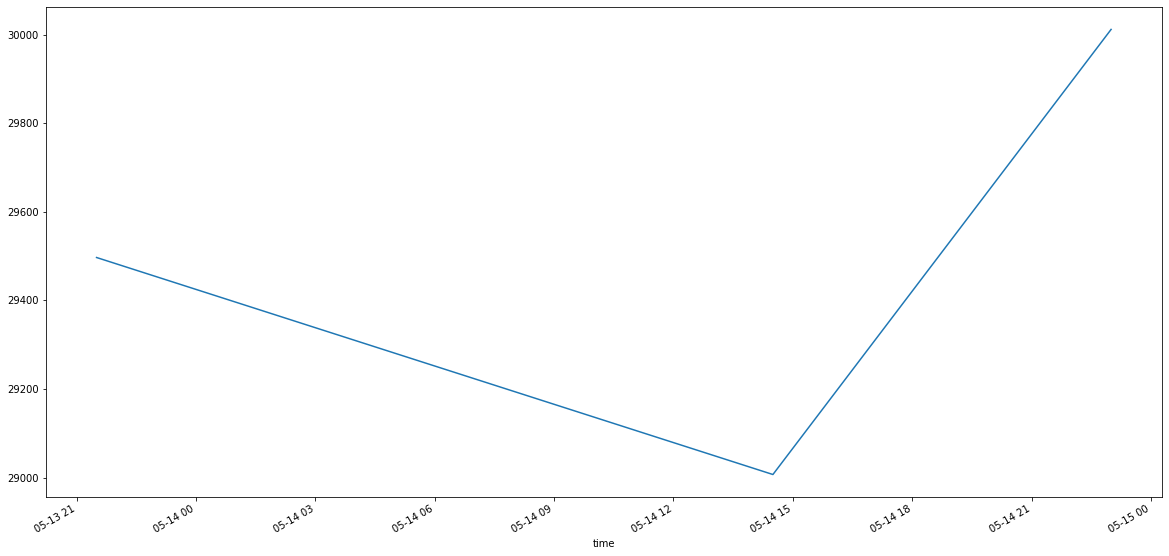

In [139]:
bitcoin_df['close'].plot(figsize=(20,10))

<AxesSubplot:xlabel='time'>

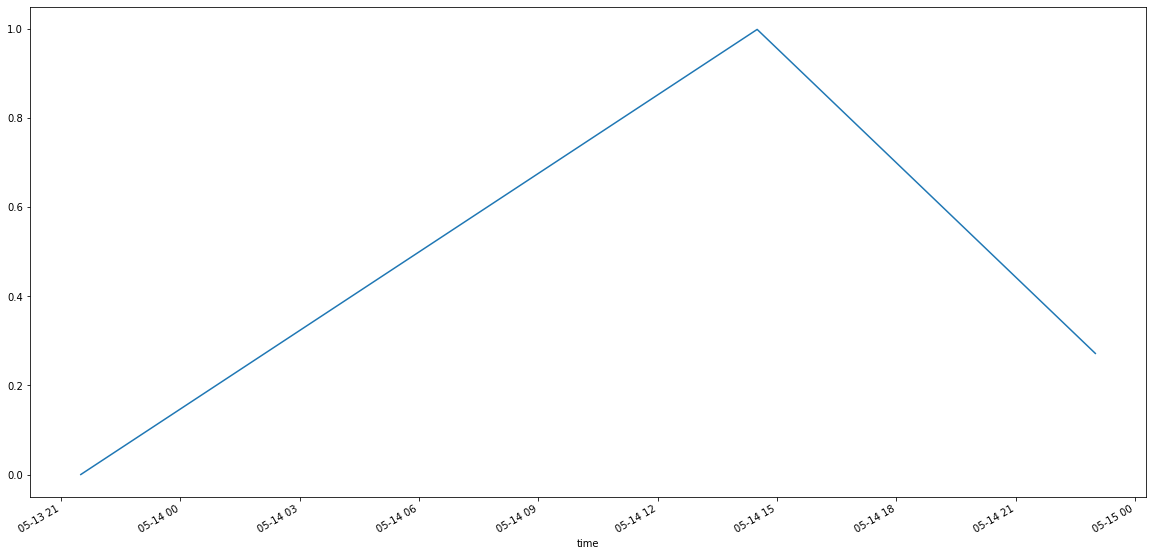

In [174]:
# minmax scale it
bitcoin_df['returns'] = (bitcoin_df['returns']-bitcoin_df['returns'].min()) / (bitcoin_df['returns'].max()-bitcoin_df['returns'].min())
bitcoin_df['returns'].plot(figsize=(20,10))

In [378]:
bull_lexicon = ['buy','call','forward','long','up','grow','rise','green','hold','carry','bull']
bear_lexicon = ['short','sell','down','drop','decrease','red','bear']

In [379]:
sentiment['bull_count'] = sentiment['text'].apply(lambda x: any(substring in x for substring in bull_lexicon))
sentiment['bear_count'] = sentiment['text'].apply(lambda x: any(substring in x for substring in bear_lexicon))

<AxesSubplot:xlabel='created_at'>

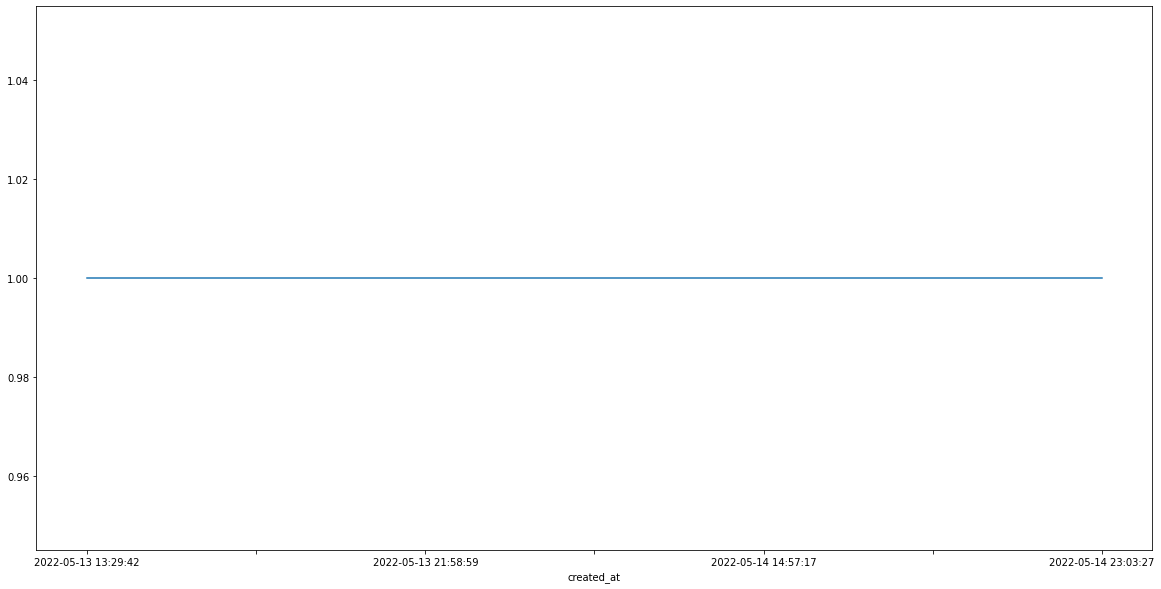

In [177]:
counts_per_day = twitter_df.reset_index().groupby('created_at')['index'].count()
counts_per_day.plot(figsize=(20,10))

In [380]:
sentiment['score'] = sentiment['like_count'].astype(int)
sentiment['score'] = sentiment[['like_count']].apply(lambda x: x.fillna(x.mean()))
sentiment['abs_score'] = np.abs(sentiment['like_count'])

#Clustering
sentiment = pd.merge(sentiment.drop('abs_score', axis=1), 
                                 sentiment.groupby('created_at')['abs_score'].sum(), left_on='created_at', right_index=True)

exp_scalar = 1.1
# Normalize score by total (absolute) score for that day
sentiment['score_w'] = sentiment['like_count']**exp_scalar /sentiment['abs_score']
sentiment = sentiment.drop(['abs_score'], axis=1)
sentiment['compound_sa'] = sentiment['compound_sa'] * sentiment['score_w']
sentiment['neg_sa'] = sentiment['neg_sa'] * sentiment['score_w']
sentiment['pos_sa'] = sentiment['pos_sa'] * sentiment['score_w']
sentiment['neu_sa'] = sentiment['neu_sa'] * sentiment['score_w']
sentiment['bull_count'] = sentiment['bull_count'] * sentiment['score_w']
sentiment['bear_count'] = sentiment['bear_count'] * sentiment['score_w']

In [383]:
sentiment.head()

,text,conversation_id,retweet_count,reply_count,like_count,quote_count,is_reply_to_user,related_user_id,Pos,Tag,...,neg_sa,pos_sa,neu_sa,compound_sa,ratio,w_sa,bull_count,bear_count,score,score_w
created_at,,,,,,,,,,,,,,,,,,,,,
2022-05-14 23:03:27,If your long term conviction of bitcoin’s valu...,1525612785375264768,378,196,2546,42,0,339061487,"['SCONJ', 'PRON', 'ADJ', 'NOUN', 'NOUN', 'ADP'...","['IN', 'PRP$', 'JJ', 'NN', 'NN', 'IN', 'NN', '...",...,0.000000,0.258504,1.932210,0.744843,NaN,0.23800,2.190715,2.190715,2546,2.190715
2022-05-14 14:57:17,"We have helped nearly 1,000 people get a new j...",1525490438093799424,50,87,331,4,0,339061487,"['PRON', 'AUX', 'VERB', 'ADV', 'NUM', 'NOUN', ...","['PRP', 'VBP', 'VBN', 'RB', 'CD', 'NNS', 'VBP'...",...,0.000000,0.216156,1.570260,1.081139,NaN,0.42364,0.000000,1.786417,331,1.786417
2022-05-13 21:58:59,Bitcoin is the best first principles solution ...,1525234174046658565,209,231,1380,24,0,339061487,"['PROPN', 'AUX', 'DET', 'ADJ', 'ADJ', 'NOUN', ...","['NNP', 'VBZ', 'DT', 'JJS', 'JJ', 'NNS', 'NN',...",...,0.263753,0.455387,1.341433,1.423444,NaN,0.48356,0.000000,0.000000,1380,2.060573
2022-05-13 13:29:42,I have officially been writing a letter on tec...,1525106011849347078,34,101,373,3,0,339061487,"['PRON', 'AUX', 'ADV', 'AUX', 'VERB', 'DET', '...","['PRP', 'VBP', 'RB', 'VBN', 'VBG', 'DT', 'NN',...",...,0.000000,0.424853,1.383032,1.638125,NaN,0.63427,1.807885,0.000000,373,1.807885
2022-05-13 02:48:56,"[NEW POST] Some Thoughts On LUNA / UST\n\n""The...",1524944753753735178,96,192,636,14,0,339061487,"['X', 'ADJ', 'PROPN', 'PUNCT', 'DET', 'PROPN',...","['XX', 'JJ', 'NNP', '-RRB-', 'DT', 'NNPS', 'IN...",...,0.812373,0.000000,1.094605,-1.853392,NaN,-0.68033,0.000000,0.000000,636,1.906978


In [384]:
sentiment = sentiment.groupby('created_at')[['like_count','compound_sa','neg_sa','pos_sa','neu_sa','bear_count','bull_count']].agg(
    {'compound_sa' : ['sum'], 
     'neg_sa' : ['sum'], 
     'neu_sa' : ['sum'], 
     'pos_sa' : ['sum'],
     'bear_count' : ['sum'],
     'bull_count' : ['sum'],
     'like_count' : ['mean']}).reset_index()

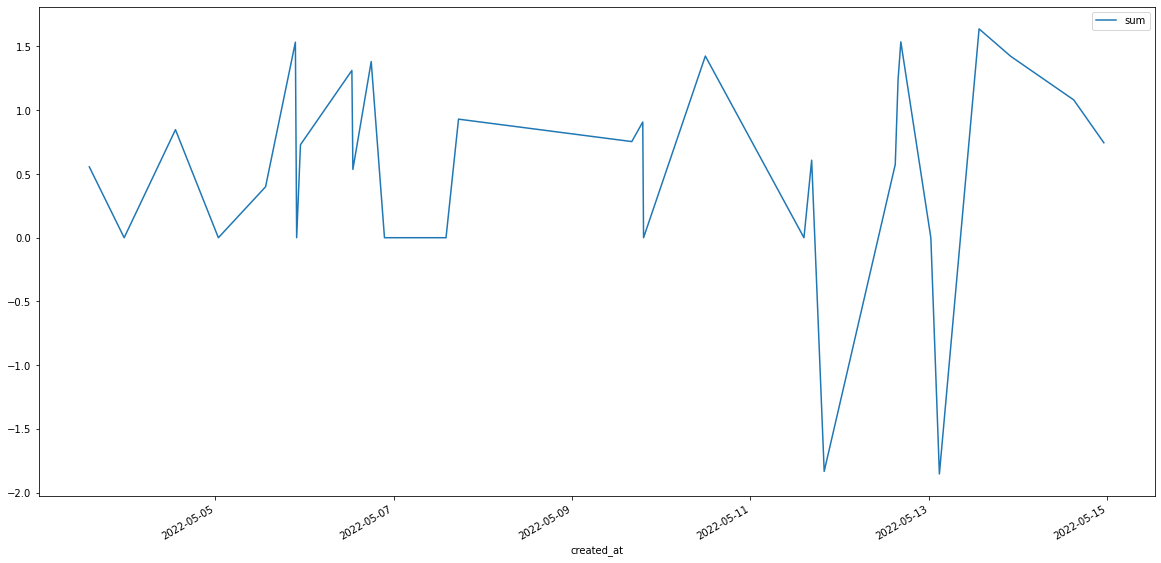

In [385]:
sentiment.plot(x = 'created_at', y = 'compound_sa', figsize=(20,10))
plt.show()

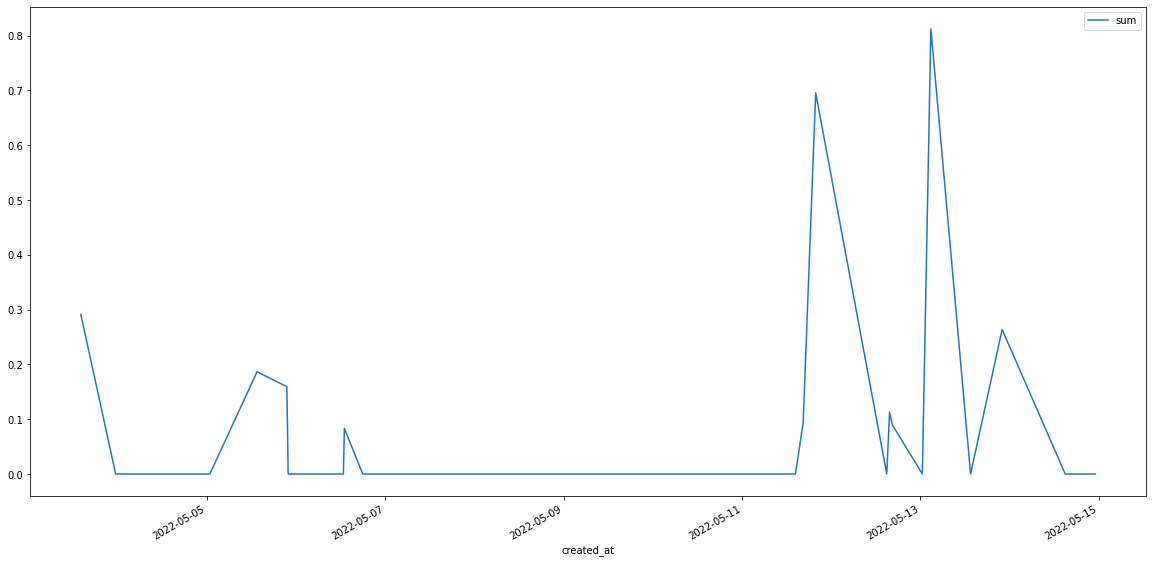

In [386]:
sentiment.plot(x = 'created_at', y = 'neg_sa', figsize=(20,10))
plt.show()

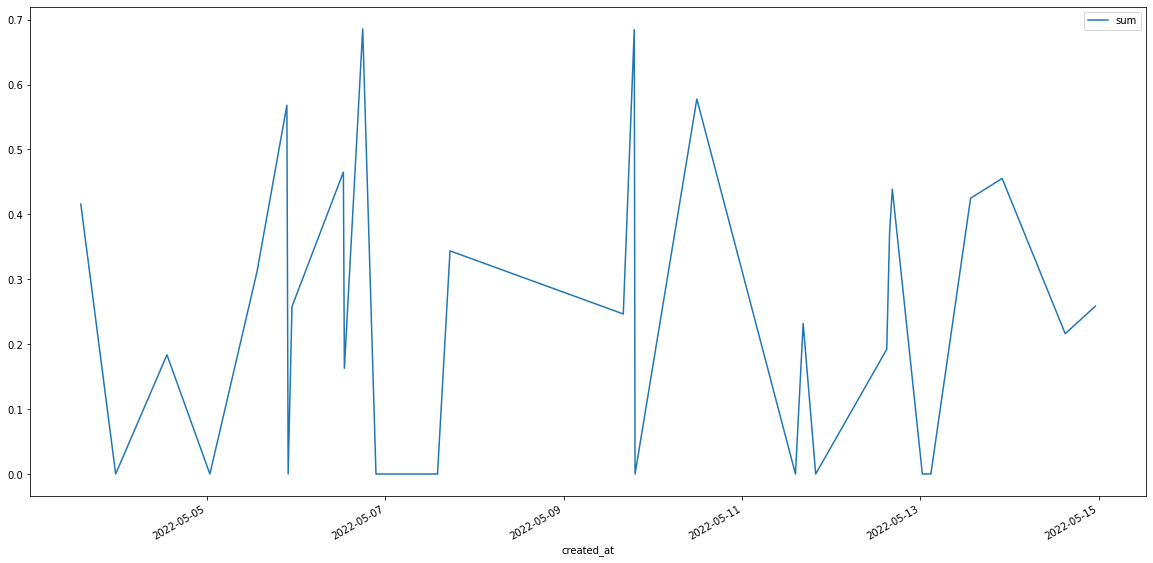

In [388]:
sentiment.plot(x = 'created_at', y = 'pos_sa', figsize=(20,10))
plt.show()

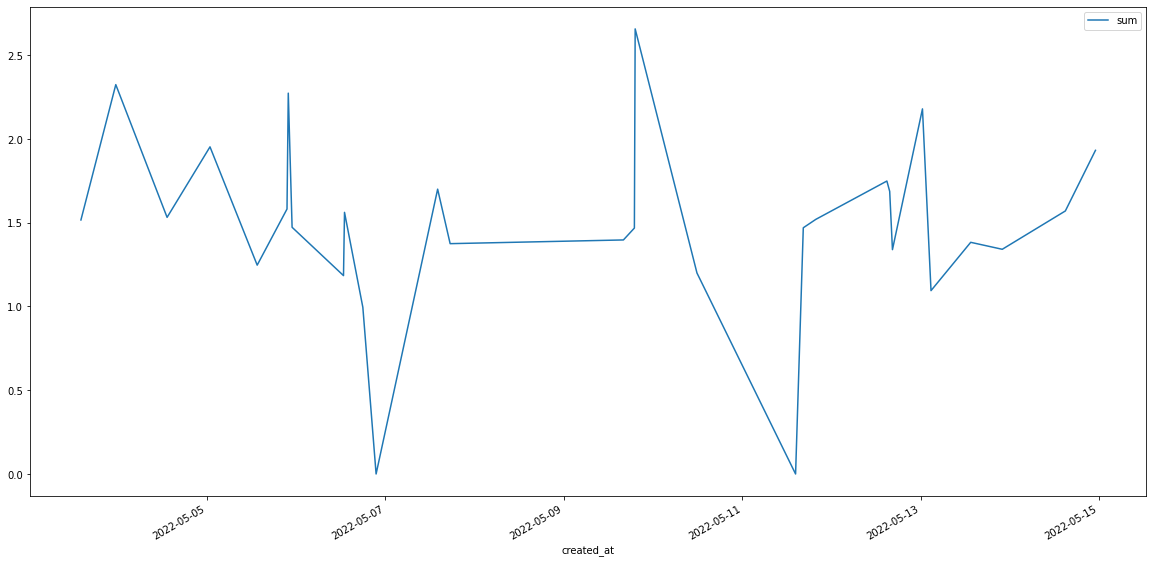

In [389]:
sentiment.plot(x = 'created_at', y = 'neu_sa', figsize=(20,10))
plt.show()

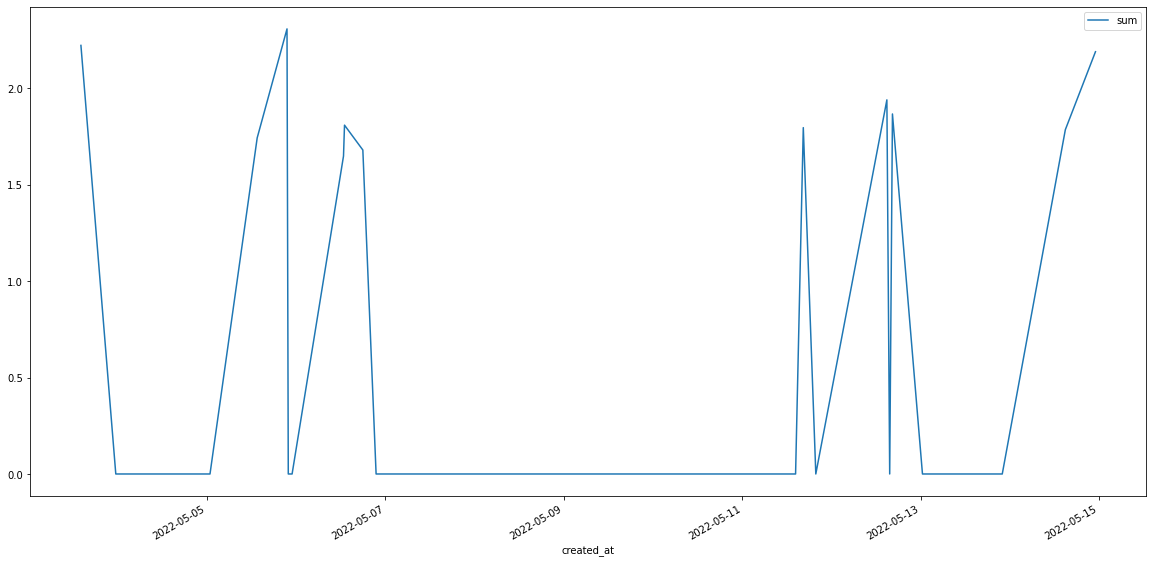

In [390]:
sentiment.plot(x = 'created_at', y = 'bear_count', figsize=(20,10))
plt.show()

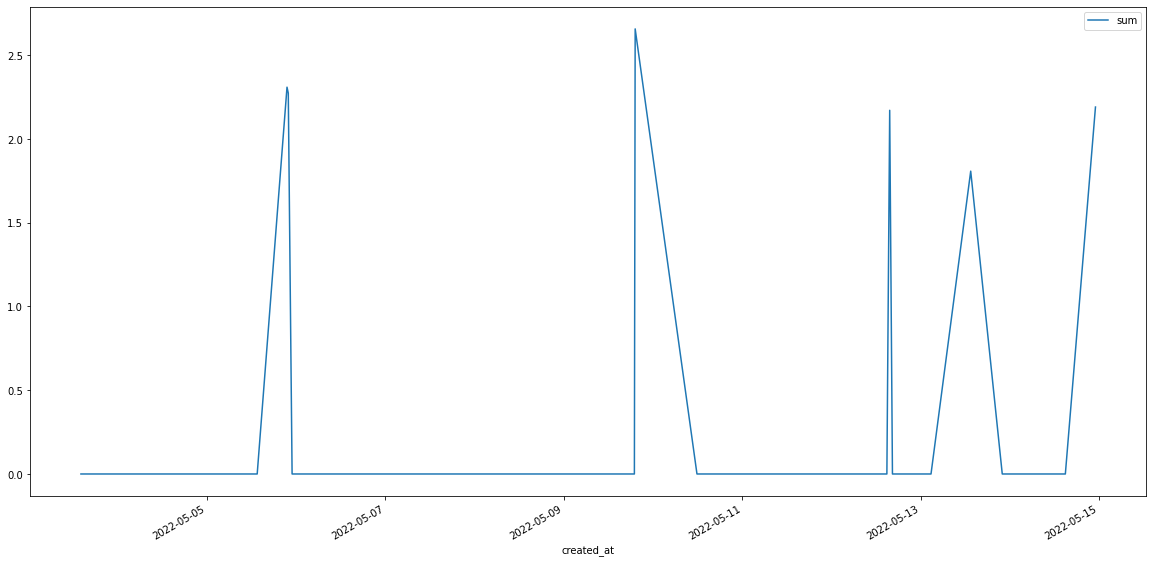

In [391]:
sentiment.plot(x = 'created_at', y = 'bull_count', figsize=(20,10))
plt.show()

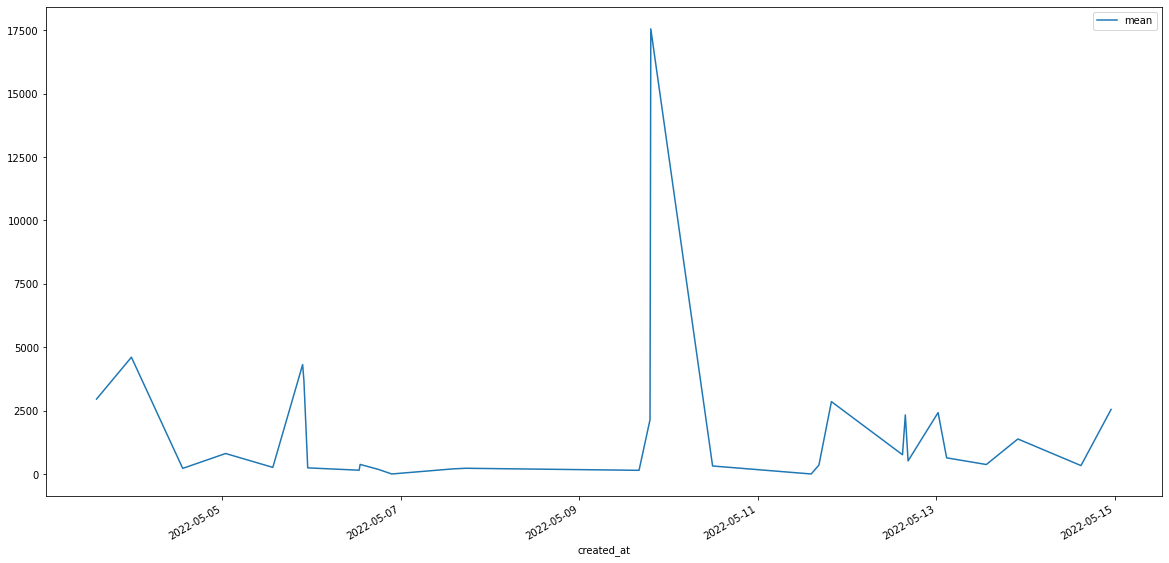

/usr/local/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [392]:
sentiment.plot(x = 'created_at', y = 'like_count', figsize=(20,10))
plt.show()
sentiment = sentiment.drop('like_count', axis=1)

In [438]:
bitcoin_df = load_bitcoin(bitcoin_data_path)
sentiment.index = sentiment['created_at']
bitcoin_sentiment, test = returns_comput(sentiment, bitcoin_df)

In [442]:
sentiment.index

DatetimeIndex(['2022-05-03 14:08:10', '2022-05-03 23:30:51',
               '2022-05-04 13:18:55', '2022-05-05 00:51:27',
               '2022-05-05 13:33:11', '2022-05-05 21:34:24',
               '2022-05-05 21:54:55', '2022-05-05 22:56:32',
               '2022-05-06 12:46:19', '2022-05-06 13:02:31',
               '2022-05-06 17:58:25', '2022-05-06 21:32:25',
               '2022-05-07 14:05:46', '2022-05-07 17:27:29',
               '2022-05-09 16:04:05', '2022-05-09 19:01:17',
               '2022-05-09 19:13:57', '2022-05-10 11:51:23',
               '2022-05-11 14:23:03', '2022-05-11 16:27:31',
               '2022-05-11 19:49:31', '2022-05-12 14:56:38',
               '2022-05-12 15:42:08', '2022-05-12 16:26:31',
               '2022-05-13 00:31:04', '2022-05-13 02:48:56',
               '2022-05-13 13:29:42', '2022-05-13 21:58:59',
               '2022-05-14 14:57:17', '2022-05-14 23:03:27'],
              dtype='datetime64[ns]', name='created_at', freq=None)

In [440]:
bitcoin_sentiment.index

DatetimeIndex(['2022-05-07 14:05:00', '2022-05-07 17:27:00',
               '2022-05-09 16:04:00', '2022-05-09 19:01:00',
               '2022-05-09 19:13:00', '2022-05-10 11:51:00',
               '2022-05-11 14:23:00', '2022-05-11 16:27:00',
               '2022-05-11 19:49:00', '2022-05-12 14:56:00',
               '2022-05-12 15:42:00', '2022-05-12 16:26:00',
               '2022-05-13 00:31:00', '2022-05-13 02:48:00',
               '2022-05-13 13:29:00', '2022-05-13 21:58:00',
               '2022-05-14 14:57:00', '2022-05-14 23:03:00'],
              dtype='datetime64[ns]', name='time', freq=None)

### Fast Fourier Transform on Sentiment Analyses

In [400]:
from scipy.fftpack import fft, ifft

def fourier(df, n_dimensions, col):
    for n in n_dimensions:
        n = round(n)
        tmp_ = fft(df[col].values)
        tmp_[n:-n] = 0
        df[str(n)+'fourier'+col] = np.abs(ifft(tmp_))
    return df

# how to choose the values of fourier?
l = len(sentiment)
sentiment = fourier(sentiment, [100, 200], 'compound_sa')
sentiment = fourier(sentiment, [100, 200], 'pos_sa')
sentiment = fourier(sentiment, [100, 200], 'neg_sa')
sentiment = fourier(sentiment, [100, 200], 'neu_sa')
returns = fourier(bitcoin_sentiment, [200, 400], 'close')

<AxesSubplot:xlabel='created_at'>

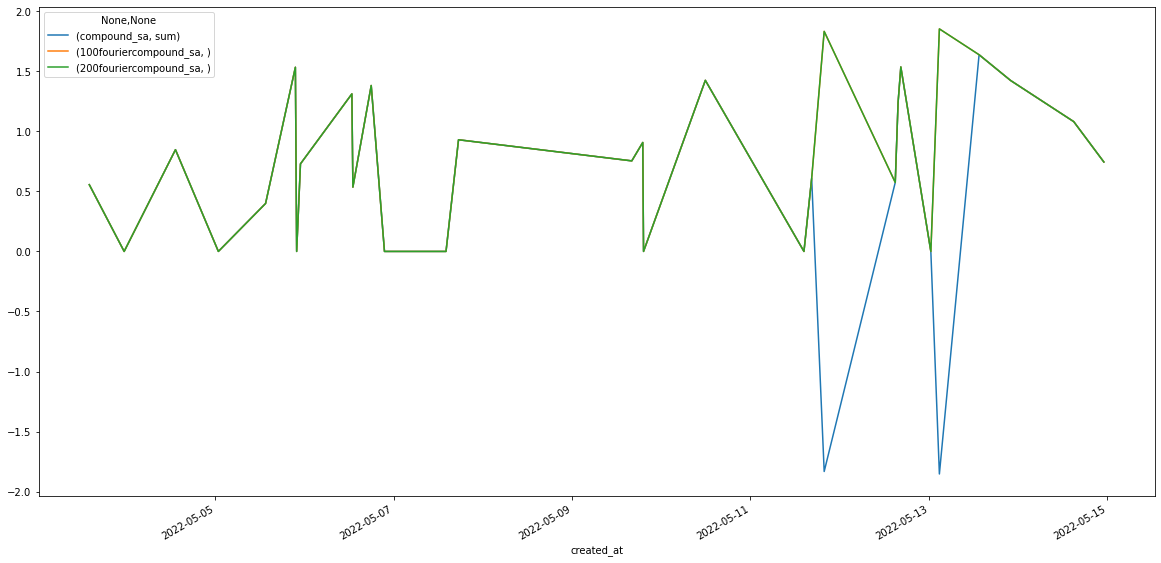

In [401]:
sentiment[['compound_sa','100fouriercompound_sa','200fouriercompound_sa']].plot(figsize=(20,10))

<AxesSubplot:xlabel='created_at'>

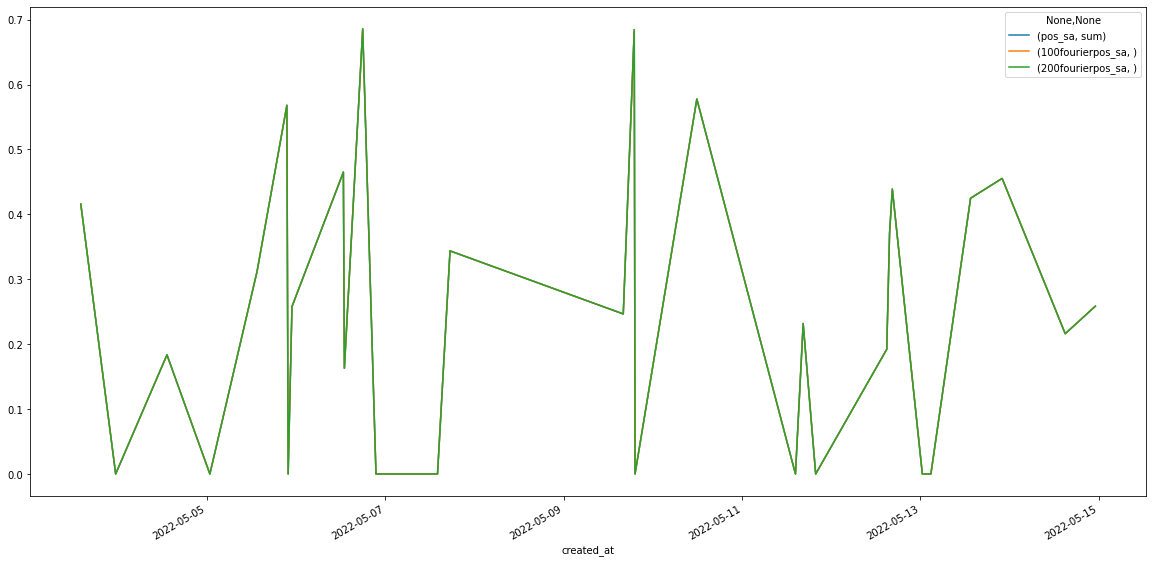

In [402]:
sentiment[['pos_sa','100fourierpos_sa','200fourierpos_sa']].plot(figsize=(20,10))

<AxesSubplot:xlabel='created_at'>

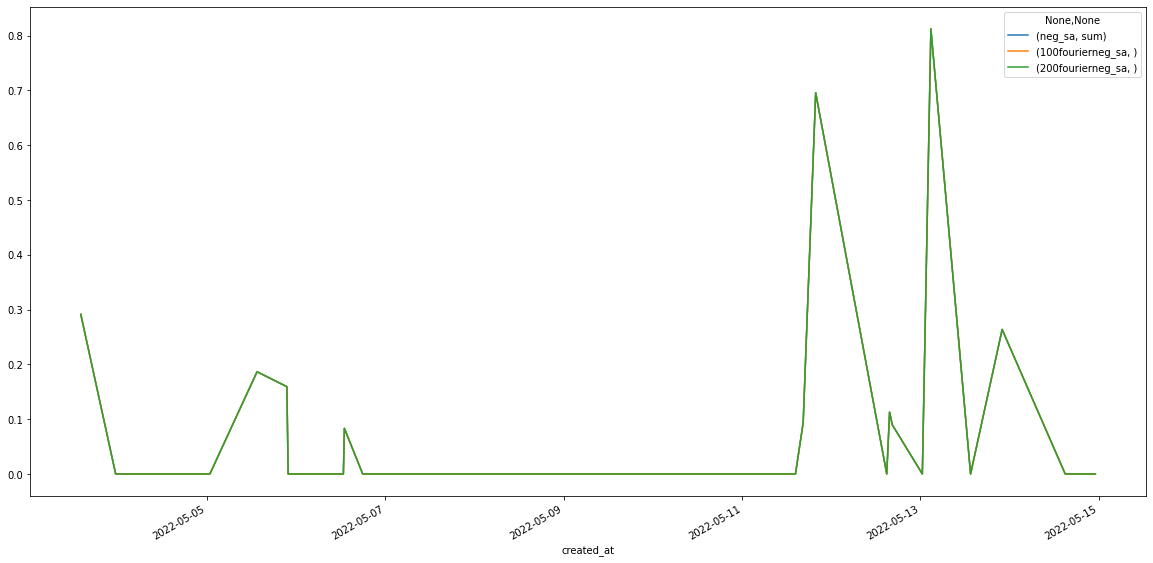

In [404]:
sentiment[['neg_sa','100fourierneg_sa','200fourierneg_sa']].plot(figsize=(20,10))

<AxesSubplot:xlabel='created_at'>

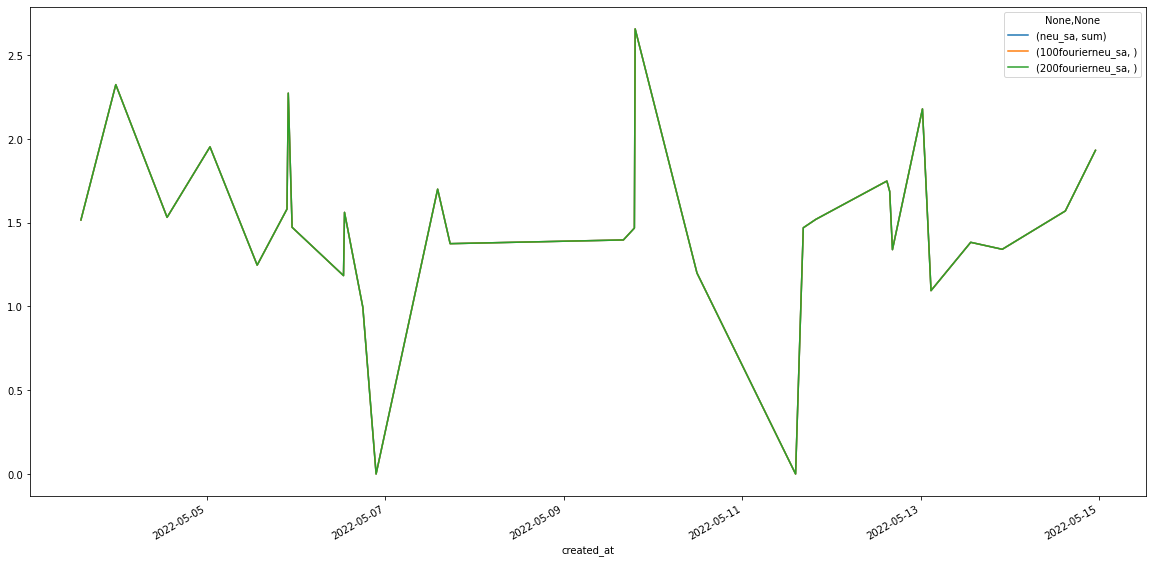

In [405]:
sentiment[['neu_sa','100fourierneu_sa','200fourierneu_sa']].plot(figsize=(20,10))

<AxesSubplot:xlabel='time'>

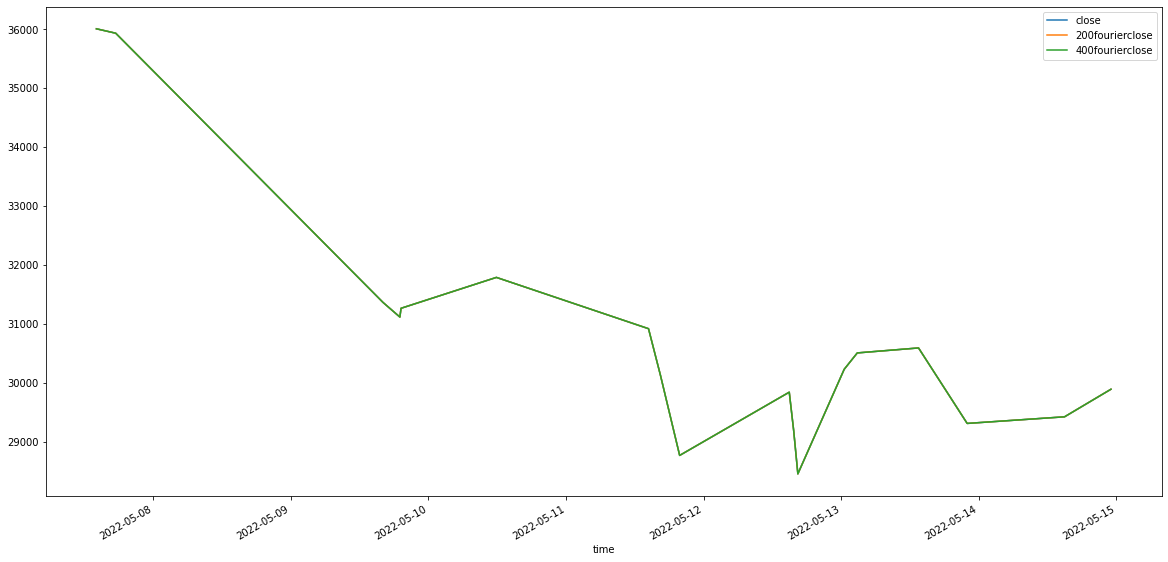

In [406]:
returns[['close','200fourierclose','400fourierclose']].plot(figsize=(20,10))

In [407]:
sentiment = sentiment.drop(['compound_sa','pos_sa','neg_sa','neu_sa'], axis=1)

/usr/local/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [433]:
test = sentiment.copy()
test = test.drop(columns=['created_at'])

/usr/local/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [434]:
test

,bear_count,bull_count,100fouriercompound_sa,200fouriercompound_sa,100fourierpos_sa,200fourierpos_sa,100fourierneg_sa,200fourierneg_sa,100fourierneu_sa,200fourierneu_sa
,sum,sum,,,,,,,,
created_at,,,,,,,,,,
2022-05-03 14:08:10,2.223520,0.000000,0.555880,0.555880,0.415798,0.415798,0.291281,0.291281,1.516441,1.516441
2022-05-03 23:30:51,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.324414,2.324414
2022-05-04 13:18:55,0.000000,0.000000,0.847380,0.847380,0.183579,0.183579,0.000000,0.000000,1.532113,1.532113
2022-05-05 00:51:27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.952933,1.952933
2022-05-05 13:33:11,1.743803,0.000000,0.399331,0.399331,0.312141,0.312141,0.186587,0.186587,1.246819,1.246819
2022-05-05 21:34:24,2.309234,2.309234,1.533793,1.533793,0.568071,0.568071,0.159337,0.159337,1.581825,1.581825
2022-05-05 21:54:55,0.000000,2.273540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.273540,2.273540
2022-05-05 22:56:32,0.000000,0.000000,0.729456,0.729456,0.257862,0.257862,0.000000,0.000000,1.472758,1.472758


In [431]:
returns

,close,volume,returns,200fourierclose,400fourierclose
time,,,,,
2022-05-07 14:05:00,36001.000000,2.328092,0.001391,36001.000000,36001.000000
2022-05-07 17:27:00,35926.000000,0.000300,-0.000139,35926.000000,35926.000000
2022-05-09 16:04:00,31360.000000,9.258464,-0.028380,31360.000000,31360.000000
2022-05-09 19:01:00,31111.000000,7.973696,0.005592,31111.000000,31111.000000
2022-05-09 19:13:00,31260.000000,14.646321,0.011258,31260.000000,31260.000000
2022-05-10 11:51:00,31784.000000,9.391418,0.003473,31784.000000,31784.000000
2022-05-11 14:23:00,30914.000000,11.956412,-0.011606,30914.000000,30914.000000
2022-05-11 16:27:00,30130.000000,25.824819,-0.020003,30130.000000,30130.000000
2022-05-11 19:49:00,28764.198570,23.070054,-0.016003,28764.198570,28764.198570


In [408]:
test = sentiment.copy()
test = test.drop(columns=['created_at'])
test.index = returns.index
test.columns = test.columns.droplevel(1)
final_df = pd.merge(test, returns, left_index=True, right_index=True)
final_df['binary'] = 1
final_df.loc[final_df.returns < 0, 'binary'] = 0
final_df.head()

ValueError: Length mismatch: Expected axis has 30 elements, new values have 18 elements

In [ ]:
def merged_df(df, df_tickers):
    final_df = pd.merge(df, df_tickers, left_on='created_at', right_on='time')
    final_df = final_df.set_index("created_at")
    return final_df

final_df = merged_df(sentiment, returns)
#final_df.to_pickle(INTERM_DIR+f'/clean/Final_df_pkl')

In [361]:
from numpy.lib.stride_tricks import sliding_window_view
y = final_df['binary']
# change between today and tomorrow is today's predictor
#y = y.pct_change()[1:].apply(lambda x: 0 if x < 0 else 1).shift(-1)
#y = y[y.index.isin(final_df.index)]
# the information throughout today is only known tomorrow ???
# investment decision is made before the open ??
X = final_df.shift(1).dropna().to_numpy()
window_size = 6
## No need to normalize, normalization happens due to feature engineering and bitcoin returns already normalized
# Create windows
# flip and flip back to make it a reverse window (t-2, t-3... t-window_size)
windowed_X = sliding_window_view(np.flip(X, axis=0), window_shape = window_size, axis=0)
windowed_X = np.flip(windowed_X, axis=0)
windowed_X = np.flip(windowed_X, axis=2)

y = y.iloc[window_size:].to_numpy()
print(windowed_X.shape)

(4, 16, 6)


### Splitting

In [362]:
import sklearn
# print(sklearn.__version__) # make sure > 0.24

X = windowed_X

trainsplit = sklearn.model_selection.TimeSeriesSplit(n_splits=2, gap = window_size, test_size = int(0.3 * X.shape[0]))

for train_index, rem_index in trainsplit.split(X):

    X_train, X_rem = X[train_index], X[rem_index]
    y_train, y_rem = y[train_index], y[rem_index]
    

valsplit = sklearn.model_selection.TimeSeriesSplit(n_splits=2, gap = window_size, test_size = int(0.33 * X_rem.shape[0]))
for val_index, test_index in valsplit.split(X_rem):

    X_val, X_test = X_rem[val_index], X_rem[test_index]
    y_val, y_test = y_rem[val_index], y_rem[test_index]
    
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

ValueError: Too many splits=2 for number of samples=4 with test_size=1 and gap=6.

In [357]:
for train_index in trainsplit.split(X):
    print('yes')

ValueError: Too many splits=2 for number of samples=4 with test_size=1 and gap=6.

In [ ]:
import pickle as pkl
with open(os.path.join(INTERM_DIR, 'train_data.pkl'), 'wb') as f:
    pkl.dump([X_train, y_train, X_val, y_val, X_test, y_test], f)

In [ ]:
with open(os.path.join(INTERM_DIR, 'train_data.pkl'), 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pkl.load(f)